# Will more data help?

Following Bayes hyperparameter search we concluded that future performance improvements would likely be the result of:

    1) More data (in the form of historical seasons)

    2) More features 

Fantasy Football Scout (FFS) (https://www.fantasyfootballscout.co.uk/) has a members area which includes player-level data going back to the 2011/2012 season. The data has many player and team-level features which are not in the current FPL API and which may be predictive of performance. However, there are also features in the FPL API which are not on FFS.

Getting the data from FFS is not trivial and would require well-defined web scraping. In this notebook we assess the potential benefits of training on more data by doing the following.

    1) Look at what features in the current FPL API and used by the current model are available on FFS

    2) Train an LSTM model (using the Bayes architecture) on the subset of available FFS features

    3) See how much worse the model is than the current one (a new FFS model would need to at least close this gap to be worthwhile)

    4) Plot a more accurate learning curve to see how performance changes with data size

## Set-up

In [169]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
from keras.layers import \
    Dense, \
    LSTM, \
    BatchNormalization, \
    Dropout, \
    Activation
from keras import \
    initializers, \
    optimizers, \
    Sequential
from hyperopt import hp, fmin, rand, tpe, Trials
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 42

## Load training data

In [6]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [7]:
all_data = load_all_data()

2020-06-07 22:50:18,018 - Loading raw historical FPL data
2020-06-07 22:50:18,228 - Creating season order column
2020-06-07 22:50:18,234 - Generating known features for next GW


In [8]:
print(all_data.shape)
all_data.head()

(67797, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [10]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [11]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.09869880673982132
Test set size: (6584, 70)
Training set size: (60124, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10238839731222141
Test set size: (6156, 70)
Training set size: (53968, 70)


In [13]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.8090184085866763
Proportion dev: 0.09228278467350243
Proportion test: 0.09869880673982132


We now get a close 80/10/10 split

In [14]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [15]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [16]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [17]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [18]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [19]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 63)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 63)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 63)
(5355, 5)


## Model using existing feature set

Load best model architecture

In [20]:
from src.models.LSTM.bayes_hyperparameter_search import create_model

In [21]:
colab_trials_dict = pickle.load(open('src/models/pickles/colab_trials_dict.pickle', 'rb'))

In [22]:
colab_trials_dict.keys()

dict_keys(['bayes_trials', 'best'])

In [23]:
bayes_trials = colab_trials_dict['bayes_trials']
best = colab_trials_dict['best']

In [24]:
best

{'batch_size': 527.0,
 'dense_dropout': 0.46,
 'dense_units': 25.0,
 'learning_rate': 0.0010974169408205815,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [25]:
hyperparams = best.copy()

In [26]:
fitting_params = {}
fitting_params['learning_rate'] = hyperparams['learning_rate']
fitting_params['batch_size'] = hyperparams['batch_size']

del hyperparams['learning_rate'], hyperparams['batch_size']

In [27]:
hyperparams

{'dense_dropout': 0.46,
 'dense_units': 25.0,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [28]:
fitting_params

{'learning_rate': 0.0010974169408205815, 'batch_size': 527.0}

In [29]:
fitting_params['batch_size'] = int(fitting_params['batch_size'])

In [30]:
INTEGER_PARAMS = ['n_lstm_layers', 'lstm_units', 'n_dense_layers', 'dense_units', 'batch_size']

for hyper in INTEGER_PARAMS:
    try:
        as_int = int(hyperparams[hyper])
        hyperparams[hyper] = as_int
    except:
        continue

In [35]:
colab_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=63, **hyperparams)

In [36]:
colab_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                4740      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 4,820
Trainable params: 4,820
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
colab_model.compile(loss='mse', optimizer=optimizer)

In [38]:
# Fit model
colab_model.fit(X_train, y_train, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev, y_dev))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 2s 35us/step - loss: 6.5371 - val_loss: 7.6259
Epoch 2/30
45691/45691 [==============================] - 1s 25us/step - loss: 5.3034 - val_loss: 6.7703
Epoch 3/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.9796 - val_loss: 6.6336
Epoch 4/30
45691/45691 [==============================] - 1s 24us/step - loss: 4.9002 - val_loss: 6.5744
Epoch 5/30
45691/45691 [==============================] - 1s 24us/step - loss: 4.8571 - val_loss: 6.5410
Epoch 6/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8349 - val_loss: 6.5155
Epoch 7/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8196 - val_loss: 6.5052
Epoch 8/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8098 - val_loss: 6.4933
Epoch 9/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.7982 - val_loss: 6.4910
Epoch 

## Feature subsets

Based on available features in Fantasy Football Scout we define 2 feature subsets:

    1) Green - available subject to validation

    2) Amber - may be possible to reconstruct

All other features are not currently on the Scout website

In [41]:
GREEN_FEATURES = [
    'assists',
    'clean_sheets',
    'creativity',
    'goals_conceded',
    'goals_scored',
    'ict_index',
    'influence',
    'minutes',
    'own_goals',
    'penalties_missed',
    'penalties_saved',
    'red_cards',
    'gw',
    'saves',
    'threat',
    'value',
    'yellow_cards',
    'position_DEF',
    'position_FWD',
    'position_GK',
    'position_MID',
    'next_match_value',
    'total_points'
]

In [47]:
ORANGE_FEATURES = [
    'bonus',
    'bps',
    'promoted_side',
    'top_6_last_season'
]

In [48]:
print(len(training_df.columns))
print(len(GREEN_FEATURES))
print(len(ORANGE_FEATURES))

69
23
4


In [43]:
def modified_prepare_data_for_lstm(df, columns_to_keep):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        player_df = player_df[columns_to_keep]
        
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

### Prep data

In [45]:
X_train_green, y_train_green = modified_prepare_data_for_lstm(training_df, columns_to_keep=GREEN_FEATURES + ['total_points_plus1_gw'])
X_dev_green, y_dev_green = modified_prepare_data_for_lstm(dev_df, columns_to_keep=GREEN_FEATURES + ['total_points_plus1_gw'])
X_test_green, y_test_green = modified_prepare_data_for_lstm(test_df, columns_to_keep=GREEN_FEATURES + ['total_points_plus1_gw'])

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 23)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 23)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 23)
(5355, 5)


In [198]:
X_train_green_and_orange, y_train_green_and_orange = modified_prepare_data_for_lstm(training_df, columns_to_keep=GREEN_FEATURES + ORANGE_FEATURES + ['total_points_plus1_gw'])
X_dev_green_and_orange, y_dev_green_and_orange = modified_prepare_data_for_lstm(dev_df, columns_to_keep=GREEN_FEATURES + ORANGE_FEATURES + ['total_points_plus1_gw'])
X_test_green_and_orange, y_test_green_and_orange = modified_prepare_data_for_lstm(test_df, columns_to_keep=GREEN_FEATURES + ORANGE_FEATURES + ['total_points_plus1_gw'])

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 27)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 27)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 27)
(5355, 5)


### Train green model

In [69]:
green_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=23, **hyperparams)

In [70]:
green_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                2340      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 2,420
Trainable params: 2,420
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
green_model.compile(loss='mse', optimizer=optimizer)

In [72]:
# Fit model
green_model.fit(X_train_green, y_train_green, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev_green, y_dev_green))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 1s 19us/step - loss: 6.8176 - val_loss: 7.5572
Epoch 2/30
45691/45691 [==============================] - 0s 8us/step - loss: 5.2979 - val_loss: 6.8439
Epoch 3/30
45691/45691 [==============================] - 0s 9us/step - loss: 5.0164 - val_loss: 6.7022
Epoch 4/30
45691/45691 [==============================] - 0s 8us/step - loss: 4.9342 - val_loss: 6.6379
Epoch 5/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8935 - val_loss: 6.5992
Epoch 6/30
45691/45691 [==============================] - 0s 8us/step - loss: 4.8628 - val_loss: 6.5759
Epoch 7/30
45691/45691 [==============================] - 0s 8us/step - loss: 4.8465 - val_loss: 6.5614
Epoch 8/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8316 - val_loss: 6.5526
Epoch 9/30
45691/45691 [==============================] - 0s 8us/step - loss: 4.8310 - val_loss: 6.5478
Epoch 10/30
45

### Train green and orange model

In [81]:
green_and_orange_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=27, **hyperparams)

In [82]:
green_and_orange_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                2580      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 2,660
Trainable params: 2,660
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
green_and_orange_model.compile(loss='mse', optimizer=optimizer)

In [84]:
# Fit model
green_and_orange_model.fit(X_train_green_and_orange, y_train_green_and_orange, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev_green_and_orange, y_dev_green_and_orange))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 1s 19us/step - loss: 6.8554 - val_loss: 7.7421
Epoch 2/30
45691/45691 [==============================] - 0s 9us/step - loss: 5.3623 - val_loss: 6.8916
Epoch 3/30
45691/45691 [==============================] - 0s 9us/step - loss: 5.0386 - val_loss: 6.7356
Epoch 4/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.9480 - val_loss: 6.6524
Epoch 5/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8938 - val_loss: 6.6062
Epoch 6/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8727 - val_loss: 6.5770
Epoch 7/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8484 - val_loss: 6.5559
Epoch 8/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8325 - val_loss: 6.5474
Epoch 9/30
45691/45691 [==============================] - 0s 9us/step - loss: 4.8218 - val_loss: 6.5367
Epoch 10/30
45

## Conclusions so far

In [96]:
# Summary of scores
pd.DataFrame({'model': ['full feature set', 'green features', 'green and orange features'], 'Dev MSE': ['6.4201', '6.5112', '6.5072']})

,model,Dev MSE
0,full feature set,6.4201
1,green features,6.5112
2,green and orange features,6.5072


In [99]:
# Features not on Fantasy Football Scout
set(training_df) - set(COLUMNS_TO_DROP_FOR_TRAINING) - set(GREEN_FEATURES) - set(ORANGE_FEATURES)

{'early_kickoff',
 'kickoff_month_Apr',
 'kickoff_month_Aug',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct',
 'kickoff_month_Sep',
 'late_kickoff',
 'next_match_early_kickoff',
 'next_match_kickoff_month_Apr',
 'next_match_kickoff_month_Aug',
 'next_match_kickoff_month_Dec',
 'next_match_kickoff_month_Feb',
 'next_match_kickoff_month_Jan',
 'next_match_kickoff_month_Mar',
 'next_match_kickoff_month_May',
 'next_match_kickoff_month_Nov',
 'next_match_kickoff_month_Oct',
 'next_match_kickoff_month_Sep',
 'next_match_late_kickoff',
 'next_match_promoted_side_opponent',
 'next_match_top_6_last_season_opponent',
 'next_match_was_home',
 'promoted_side_opponent',
 'selected',
 'team_a_score',
 'team_h_score',
 'top_6_last_season_opponent',
 'total_points_plus1_gw',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'was_home'}

- Our model with the full feature set had a MSE which was 0.08 lower than the model with just the orange and green features
- Caveats of our findings:
    - There may be a better architecture for the reduced feature sets so this difference in MSE may be overstated
    
    - In practice a model trained using the orange and green features taken from Fantasy Football Scout would have to be reframed as a prediction of `total points - bonus points` because of the lack of bonus points data

- Given that only the green and orange (after some work) features are available on Fantasy Football Scout a new model using historical season data must achieve over 0.08 MSE imporvement to be worthwhile
- Having said this Bayes search alone led to a 0.13 improvement on the dev set (6.57 to 6.42)
- To see whether this is likely we can plot a learning curve
- We will use a custom function (rather than sklearn's implementation) to account for the fact that cross-validation does not work in our case


## Learning curve

In [166]:
def custom_learning_curve(X, y, increment_prop, validation_data):
    total_examples = X.shape[0]
    increments = int(increment_prop * total_examples)
    
    batches = [
        (X[:i, :, :], y[:i, :]) for i in np.arange(increments, total_examples, increments)
    ]
    results_df = pd.DataFrame()
    
    for batch in batches:
        X = batch[0]
        y = batch[1]
        batch_size = X.shape[0]
        print(f"Working on batch size: {batch_size}")
        
        model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=27, **hyperparams)
        optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
        model.compile(loss='mse', optimizer=optimizer)
        
        model.fit(X, y, batch_size=fitting_params['batch_size'], epochs=30, verbose=0)
        
        mse = mean_squared_error(validation_data[1], model.predict(validation_data[0]))
        
        temp_df = pd.DataFrame({"Batch size": [batch_size], "MSE": [mse]})
        
        results_df = results_df.append(temp_df)
        
    return results_df

In [176]:
learning_curve_data = custom_learning_curve(X_train_green_and_orange, y_train_green_and_orange, 0.05, validation_data=(X_dev_green_and_orange, y_dev_green_and_orange))

Working on batch size: 2284
Working on batch size: 4568
Working on batch size: 6852
Working on batch size: 9136
Working on batch size: 11420
Working on batch size: 13704
Working on batch size: 15988
Working on batch size: 18272
Working on batch size: 20556
Working on batch size: 22840
Working on batch size: 25124
Working on batch size: 27408
Working on batch size: 29692
Working on batch size: 31976
Working on batch size: 34260
Working on batch size: 36544
Working on batch size: 38828
Working on batch size: 41112
Working on batch size: 43396
Working on batch size: 45680


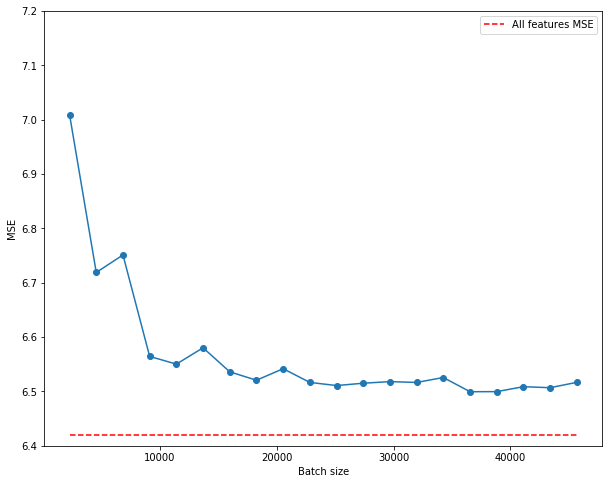

In [189]:
plt.figure(figsize=(10,8))
plt.ylim(6.4, 7.2)
plt.plot(learning_curve_data['Batch size'], learning_curve_data['MSE'], marker='o')
plt.hlines(6.4201, learning_curve_data['Batch size'].min(), learning_curve_data['Batch size'].max(), linestyles='--', colors='red', label='All features MSE')
plt.xlabel('Batch size')
plt.ylabel('MSE')
plt.legend()

- Can see that the learning curve plateaus relatively early on. 
- As such adding more data is unlikely to lead to better performance than the current model which uses FPL API features.
- Therefore if we are to use FFS data we should only use it to get new features which are not available in the FPL API.
- Even then the new features may not compensate for the missing features. Should maybe explore feature importance to see which of the missing features is most important to the model.